In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import astropy as ap
from astropy import units as u
import kcorrect
import kcorrect.utils as ut
from astropy.cosmology import FlatLambdaCDM
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import custom_model
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord

In [3]:
from itertools import combinations
import os
import datetime
import matplotlib.backends.backend_pdf

In [4]:
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)

In [5]:
kcordir=os.environ["KCORRECT_DIR"]
catbasedir=os.environ["COSMOS_DIR"]

In [6]:
print('Reading in Catalogs')
COSMOS_PHOT_LAMBDAR=pd.read_csv(catbasedir+'/Final_Catalogs/COSMOS_CONVERTED_CATALOG.csv')
TASCA_COSMOS_MORPH=pd.read_csv(
    catbasedir+'/Morphology/cosmos_morph_tasca_1.1.tbl',
    delim_whitespace=True,
    header=0,
    dtype=float,
    error_bad_lines=False,
    skiprows=[1,2,3])

Reading in Catalogs


In [7]:
TASCA_COORD=SkyCoord(ra=TASCA_COSMOS_MORPH['RA'].values*u.degree,dec=TASCA_COSMOS_MORPH['DEC'].values*u.degree)
G10_COORD=SkyCoord(ra=COSMOS_PHOT_LAMBDAR['RA'].values*u.degree,dec=COSMOS_PHOT_LAMBDAR['DEC'].values*u.degree)

In [11]:
idx,d2d,d3d=G10_COORD.match_to_catalog_sky(TASCA_COORD)
COSMOS_PHOT_LAMBDAR['R_HALF_PIXELS']=TASCA_COSMOS_MORPH['R_HALF'][idx].values
COSMOS_PHOT_LAMBDAR['Morphology_Int']=TASCA_COSMOS_MORPH['CLASS_INT'][idx].values
COSMOS_PHOT_LAMBDAR['SEPARATION']=d2d.arcsecond
COSMOS_PHOT_LAMBDAR.loc[COSMOS_PHOT_LAMBDAR.SEPARATION>0.1,'R_HALF_PIXELS']=np.nan
COSMOS_PHOT_LAMBDAR.loc[COSMOS_PHOT_LAMBDAR.SEPARATION>0.1,'Morphology_Int']=np.nan
COSMOS_FLUXES=COSMOS_PHOT_LAMBDAR

In [12]:
COSMOS_FLUXES

,Unnamed: 0,Unnamed: 0.1,CATAID,COSMOS_ID_06,COSMOS_ID_08,COSMOS_ID_13,I_MAG_AUTO,RA,DEC,RA_06,...,BJ0_synthetic_vega_mag,VJ0_synthetic_vega_mag,rest_frame_B-V,BJ0_synthetic_vega_absmag,BJ0_vega_absmag,BJ0_vega_surface_brightness,R_HALF_ARCSEC_F814W,R_HALF_ARCSEC_B,is_LCBG,Morphology_Int
0,0,0,6228949,-9999,-9999.0,-9999.0,-9999.000000,150.284907,2.274969,150.28495,...,27.042866,26.326327,0.716539,-15.556783,-15.399082,NaN,NaN,NaN,0,NaN
1,1,1,6228950,1562896,969860.0,-9999.0,-9999.000000,150.285343,2.274818,150.28538,...,27.709038,26.714897,0.994141,-15.211059,-14.777205,NaN,NaN,NaN,0,NaN
2,2,2,6229081,1563735,969829.0,183708.0,-9999.000000,150.286185,2.272333,150.28616,...,24.777025,24.574711,0.202313,-21.968082,-21.699117,16.595929,0.111194,0.103063,1,2.0
3,3,3,6229234,1564832,971788.0,-9999.0,-9999.000000,150.284185,2.280436,150.28418,...,25.950100,25.511662,0.438438,-17.684766,-17.959603,NaN,NaN,NaN,0,NaN
4,4,4,6008198,1560828,969208.0,-9999.0,-9999.000000,150.319706,2.286608,150.31969,...,20.204421,18.960575,1.243845,-18.566558,-19.036829,NaN,NaN,NaN,0,NaN
5,5,5,6228502,1560492,968651.0,-9999.0,-9999.000000,150.525985,2.285622,150.52596,...,25.692080,25.151003,0.541077,-16.787045,-16.800244,NaN,NaN,NaN,0,NaN
6,6,6,6228519,1560533,968682.0,-9999.0,-9999.000000,150.524440,2.285501,150.52444,...,31.561252,31.076955,0.484298,-10.315075,-10.471325,NaN,NaN,NaN,0,NaN
7,7,7,6228521,1560535,968683.0,-9999.0,-9999.000000,150.525249,2.286665,150.52519,...,30.633752,30.818037,-0.184285,-12.089825,-10.831132,NaN,NaN,NaN,0,NaN
8,8,8,6612005,-9999,-9999.0,-9999.0,-9999.000000,150.525807,2.288542,-9999.00000,...,30.661646,30.012667,0.648978,NaN,NaN,NaN,NaN,NaN,0,NaN
9,9,9,6228522,-9999,-9999.0,-9999.0,-9999.000000,150.525540,2.288525,150.52555,...,29.698889,29.783252,-0.084363,NaN,NaN,NaN,NaN,NaN,0,NaN


In [13]:
COSMOS_FLUXES['BJ0_vega_surface_brightness']=\
(COSMOS_FLUXES['BJ0_vega_absmag']+
 2.5*np.log10(
     2*np.pi*
     np.power(1/cosmo.arcsec_per_kpc_proper(COSMOS_FLUXES.Z_BEST.values).value*
              (
                  (
                      COSMOS_FLUXES.R_HALF_PIXELS.values*
                      0.03
                  )
              )
              ,2)
 )
 +2.5*np.log10((360*60*60/(2*np.pi*0.01))**2))

/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1922: RuntimeWarning: invalid value encountered in sqrt
  return 2 * np.sqrt(x) * hyp2f1(1./6, 1./2, 7./6, -x**3)
/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


In [14]:
COSMOS_FLUXES['R_HALF_ARCSEC_F814W']=COSMOS_FLUXES.loc[:,'R_HALF_PIXELS']*0.03
COSMOS_FLUXES['R_HALF_ARCSEC_B']=COSMOS_FLUXES.loc[:,'R_HALF_PIXELS']*0.03*(814/(445*(1+COSMOS_FLUXES.Z_BEST.values)))**0.108
COSMOS_FLUXES['is_LCBG']=0
COSMOS_FLUXES.loc[(COSMOS_FLUXES.BJ0_vega_absmag.values<-18.5)&(COSMOS_FLUXES.BJ0_vega_surface_brightness.values<21)&(COSMOS_FLUXES['rest_frame_B-V'].values<0.6),'is_LCBG']=1

/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [19]:
Spiral_LCBGS=COSMOS_FLUXES.loc[(COSMOS_FLUXES.is_LCBG==1)&
                  (COSMOS_FLUXES.Morphology_Int==1)&
                  (COSMOS_FLUXES.SG_MASTER==0)&
                 (COSMOS_FLUXES.Z_BEST<1.0)]
Elliptical_LCBGS=COSMOS_FLUXES.loc[(COSMOS_FLUXES.is_LCBG==1)&
                  (COSMOS_FLUXES.Morphology_Int==1)&
                  (COSMOS_FLUXES.SG_MASTER==0)&
                 (COSMOS_FLUXES.Z_BEST<1.0)]
Irregular_LCBGS=COSMOS_FLUXES.loc[(COSMOS_FLUXES.is_LCBG==1)&
                  (COSMOS_FLUXES.Morphology_Int==1)&
                  (COSMOS_FLUXES.SG_MASTER==0)&
                 (COSMOS_FLUXES.Z_BEST<1.0)]

In [20]:
N_LCBG_10_35=Spiral_LCBGS.loc[(Spiral_LCBGS.Z_BEST>0.1)&Spiral_LCBGS.Z_BEST<0.35)&]

SyntaxError: invalid syntax (<ipython-input-20-20f4ef6ce17d>, line 1)

In [30]:
COSMOS_FLUXES.to_csv(catbasedir+'/Final_Catalogs/COSMOS_CONVERTED_CATALOG.csv')

(array([2.000e+00, 2.000e+00, 2.000e+00, 1.300e+01, 3.400e+01, 5.500e+01,
        5.700e+01, 6.300e+01, 5.000e+01, 2.600e+01, 3.500e+01, 4.500e+01,
        5.100e+01, 1.170e+02, 2.870e+02, 3.430e+02, 4.320e+02, 4.890e+02,
        6.180e+02, 8.630e+02, 1.178e+03, 1.595e+03, 2.096e+03, 2.902e+03,
        3.529e+03, 4.422e+03, 5.347e+03, 6.035e+03, 6.560e+03, 7.339e+03,
        7.828e+03, 8.071e+03, 7.892e+03, 7.318e+03, 6.510e+03, 5.581e+03,
        4.446e+03, 3.485e+03, 2.547e+03, 1.706e+03, 1.151e+03, 7.200e+02,
        4.600e+02, 2.960e+02, 1.420e+02, 8.400e+01, 4.700e+01, 2.000e+01,
        1.000e+01, 9.000e+00, 9.000e+00, 5.000e+00, 0.000e+00, 3.000e+00,
        3.000e+00, 4.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 3.000e+00]),
 array([10.        , 10.33333333, 10.66666667, 11.        , 11.33333333,
        11.66666667, 12.        , 12.33333333, 12.66666667, 13.        ,
        13.33333333, 13.66666667, 14.        , 14.33333333, 14.66666667,
        15.        , 15.33333333, 15.66

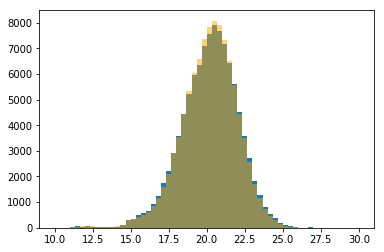

In [27]:
plt.hist(COSMOS_FLUXES['BJ0_vega_surface_brightness'],range=[10,30],bins=60)
plt.hist(surfacebrightnessi,range=[10,30],bins=60,color='orange',alpha=0.5)